<a href="https://colab.research.google.com/github/reinhardbuyabo/ICS4102/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Time Series Forecasting

In [1]:
!pip install utilsforecast

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("/content/daily_sales_french_bakery.csv")
df = df.groupby("unique_id").filter(lambda x: len(x) >= 28)
df = df.drop(["unit_price"], axis=1)
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


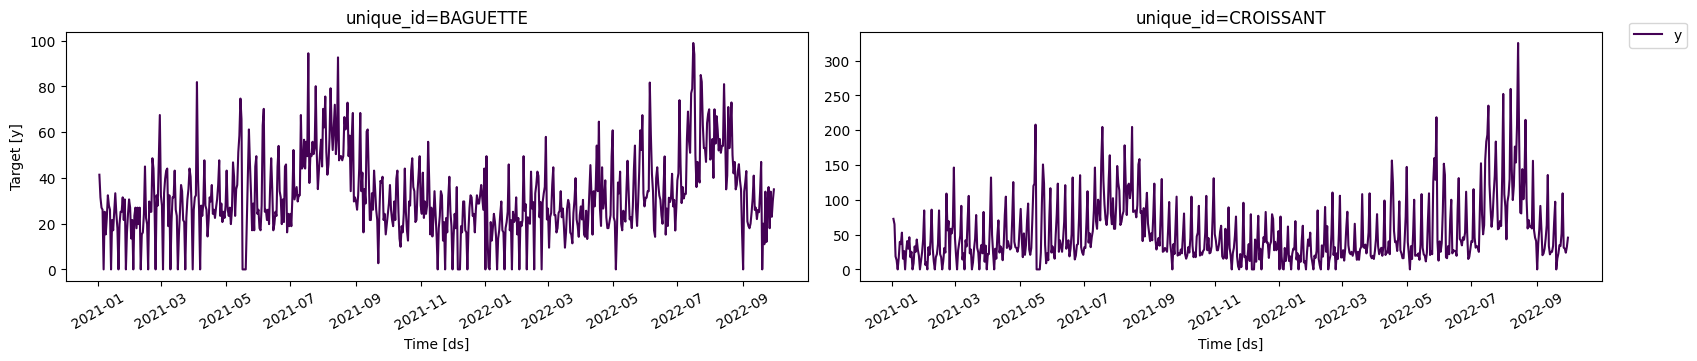

In [4]:
from utilsforecast.plotting import plot_series

plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], palette="viridis")

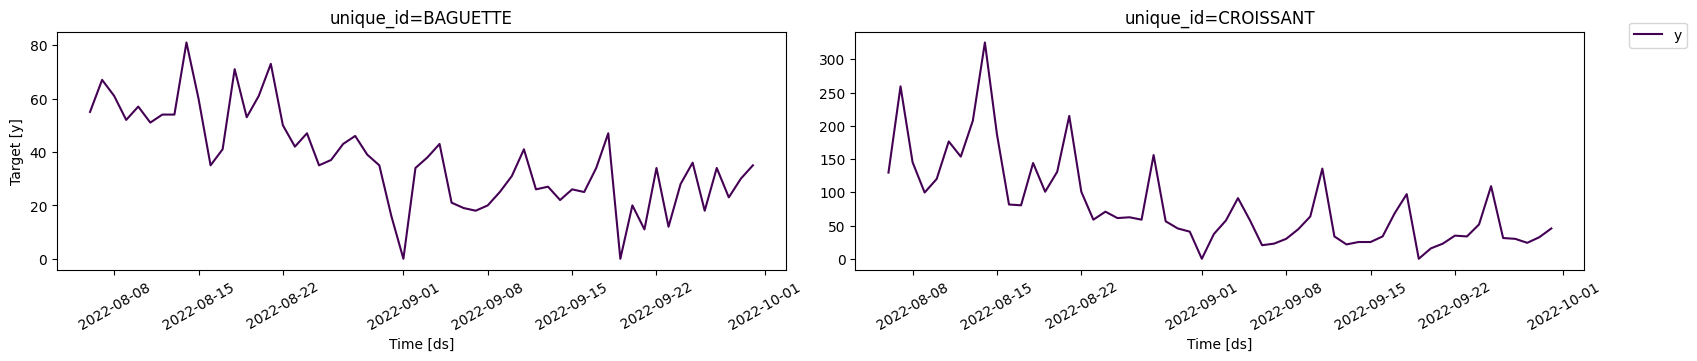

In [5]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")

## Baseline Modelling

In [6]:
!pip install statsforecast

In [7]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [8]:
horizon = 7

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=df)
preds = sf.predict(h=horizon)

In [9]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


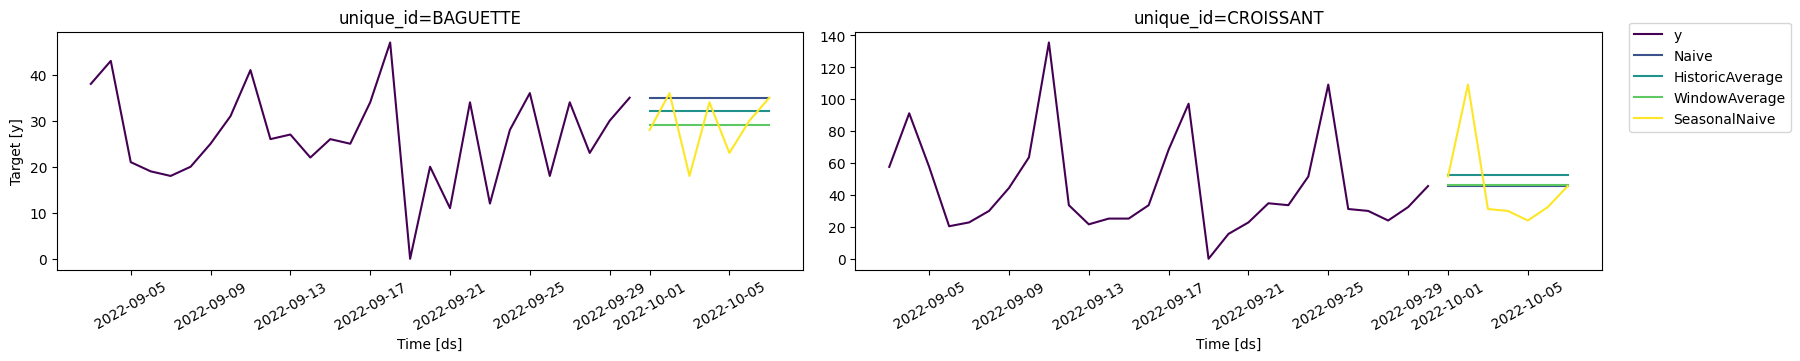

In [10]:
plot_series(
    df=df,
    forecasts_df=preds,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=28,
    palette="viridis")

## Evaluate Baseline Models

In [11]:
test = df.groupby("unique_id").tail(7)
train = df.drop(test.index).reset_index(drop=True)

In [12]:
sf.fit(df=train)

preds = sf.predict(h=horizon)

eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])

In [20]:
from utilsforecast.losses import mae
from utilsforecast.evaluation import evaluate

evaluation = evaluate(
    eval_df,
    metrics=[mae],
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


AutoARIMA

In [23]:
from statsforecast.models import AutoARIMA

In [26]:
unique_ids = ["BAGUETTE", "CROISSANT"]

small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

# trying out 2 different models
# setting seasonal to false
# alias = ARIMA without the seasonal component
# next we'll specify the seasonal component, and compare wchich component performs best
models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D") # Frequence is daily
sf.fit(df=small_train) # small training set
arima_preds = sf.predict(h=horizon) # horizon is 7 days

# evaluation dataframe
arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae],
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449083,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143


In [27]:
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


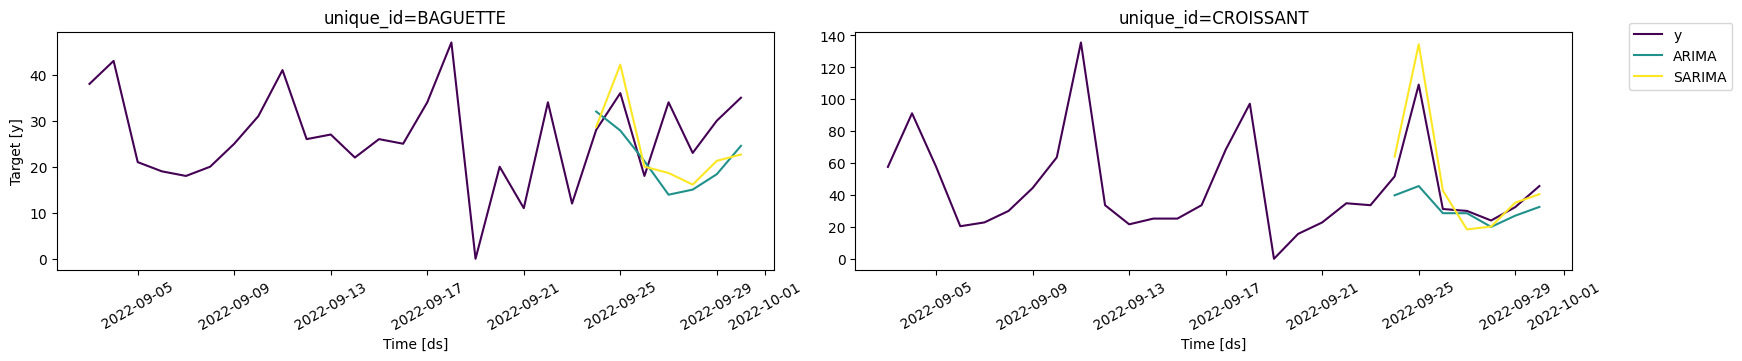

In [28]:
plot_series(
    df=df,
    forecasts_df=arima_preds,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=28,
    palette="viridis")

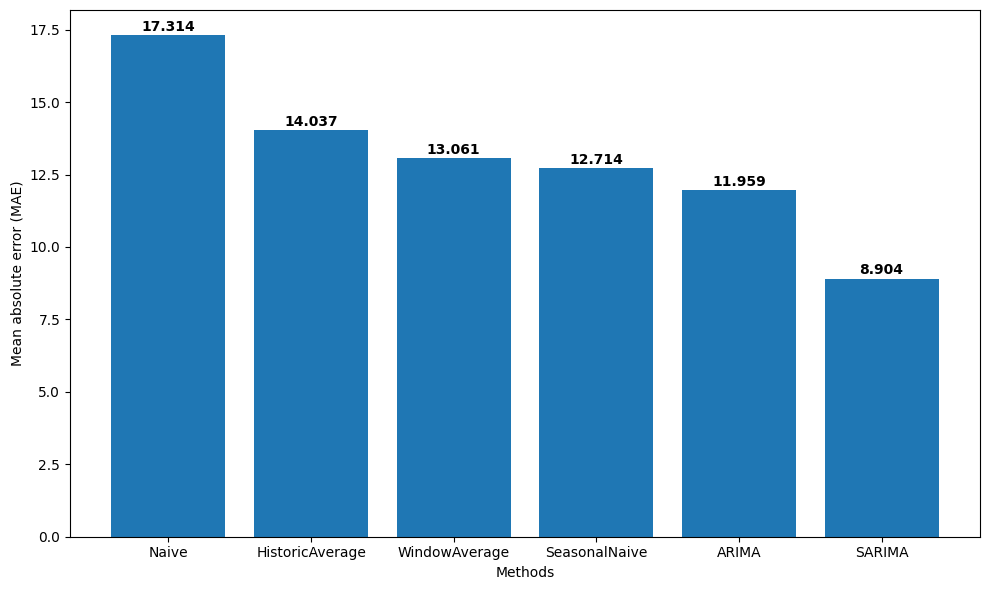

In [29]:
methods = arima_eval.columns[1:].tolist()
values = arima_eval.iloc[0, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

## Cross-Validation
- Evaluating on a single forecast period is not enough
1. There are few data points
2. Not representative of the model's forecasting capability

- Use cross-validation to forecast on many windows for a more reliable evaluation

- Cross Validation in time series should ensure order remains, no shuffling of data.
- Data is ordered in time so, the order should remain fixed
### INPUT & FORECAST

- Start with input window.
- Make a forecast within a certain horizon
- Then update the input sequence then forecast the next window.
- Repeat process until you run out of data.

- Forecast a certain horizon and wait for new data.
- Use new data as an input to the model.

- Use cross-validation for various models

In [31]:
# baguette and croissant
small_df = df[df["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=7), # best benchmark
    AutoARIMA(seasonal=False, alias="ARIMA"), #
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D") # daily frequency

# cross validation dataframe
cv_df = sf.cross_validation(
    h=horizon, # 7 days # timestamps you're forecasting
    df=small_df, # entire dataframe since it will make the windows for us
    n_windows=8, # horizon of 8, we have windows of 7 forecasts 8*7 = 56
    step_size=horizon, # distance between starting date of each window # so that we don't get overlapping windows , if step size is less # using step_size=horizon is the best way to go, and fastest way to run cross validation
    refit=True # determines whether you want to refit your model if the input changes # train your model once train forecast a couple of times
)

cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,71.355196,71.584713
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,70.337980,78.458883
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,61.195004,57.001732
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,52.649013,49.401144
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,47.785876,49.725278


In [33]:
cv_eval = evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_eval

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.17093,19.281296


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['SeasonalNaive']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'SeasonalNaive'}, axis=1)
              .sort_values('SeasonalNaive', ascending=True))
  xs = counted['SeasonalNaive']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('SeasonalNaive', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SeasonalNaive')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ARIMA']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ARIMA'}, axis=1)
              .sort_values('ARIMA', ascending=True))
  xs = counted['ARIMA']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('ARIMA', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ARIMA')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['SARIMA']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'SARIMA'}, axis=1)
              .sort_values('SARIMA', ascending=True))
  xs = counted['SARIMA']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('SARIMA', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SARIMA')
_ = plt.ylabel('count()')

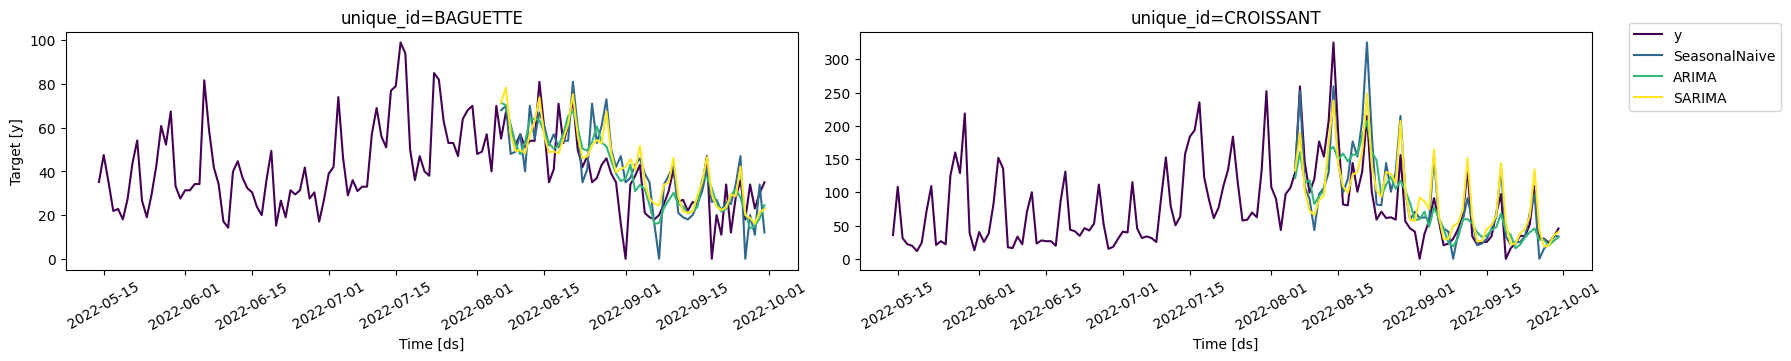

In [35]:
plot_series(
    df=small_df,
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=140,
    palette="viridis")

## Forecasting with exogenous features
- Exogenous features are external variables that are not part of the time series itself
  - values of another series
  - holidays
  - any external factor

- Ex: forecasting electriciy demand, features can include
  - temp outside
  - hour of the day


### Exogenous features
1. Static features stay constant in time Ex: a product category
2. Historical features the vlaues are known in the past, but are unknown in the future Ex: the price of gas
3. Future features the values are known both in the past and in the future
Ex: the data of national holidays

## Create Exogenous Features
- Useful when we have complex seasonalities or dependency to time features
  - Use Fourier terms for seasonality
  - Encode timestamps as features (days of week, month of year, etc)

  terms of sines and cosines encode seasonality

  - Encode timestamp itself ... this is hour 1,2,3,4 ... this is day of the week 1,2,3,4,5,6,7


- Monday is day 1, Tuesday is day 2,

- Use for the future

In [38]:
df = pd.read_csv("/content/daily_sales_french_bakery.csv", parse_dates=["ds"])
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


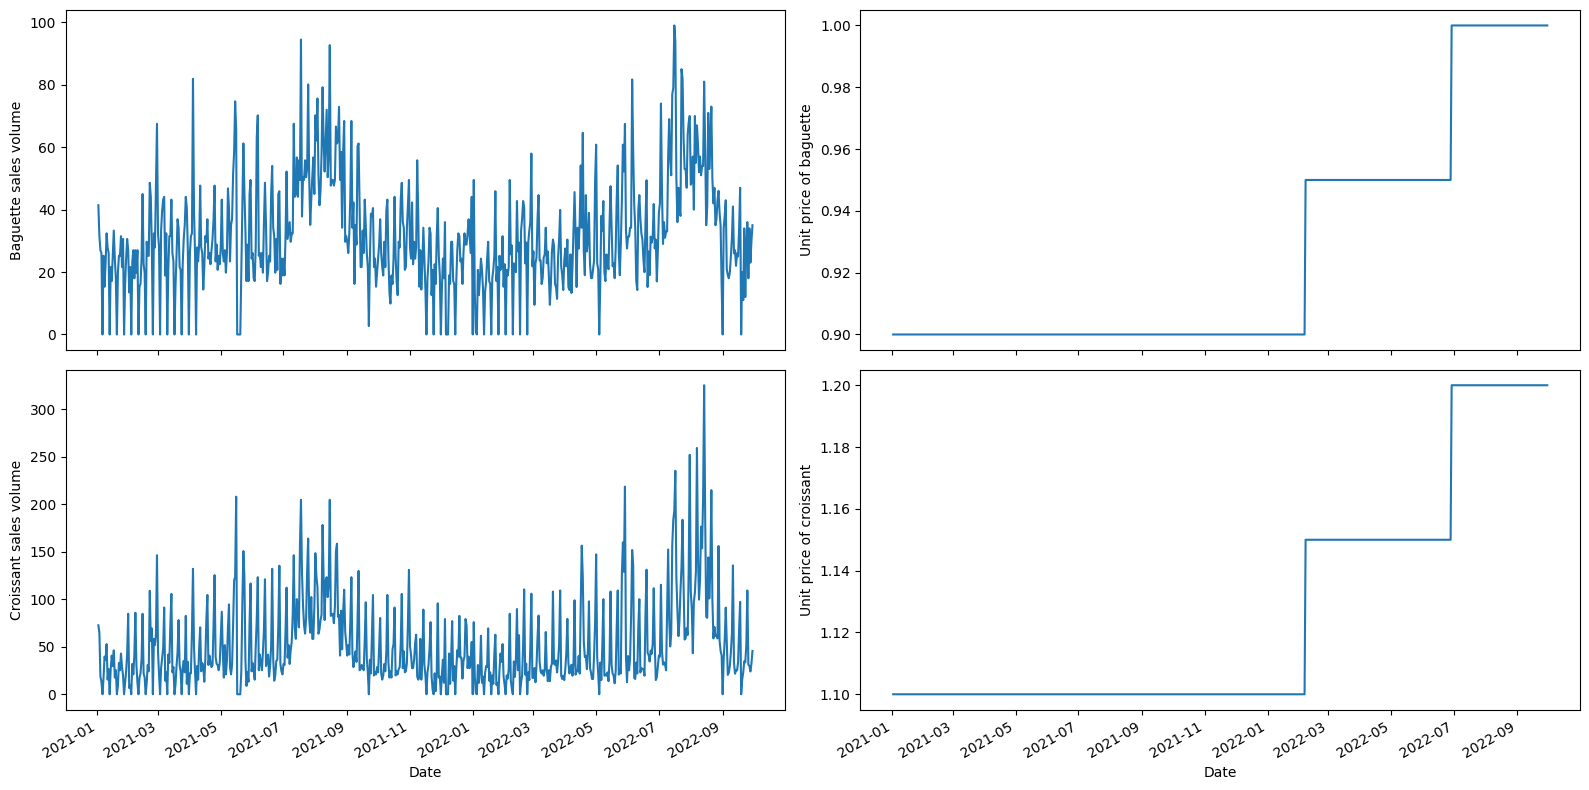

In [39]:
## price as an exogenous feature
## price increases steadily
## the bakery isn't doing discounts ... the price is increasing due to inflation | rising costs

baguette_plot_df = df[df["unique_id"] == "BAGUETTE"]
croissant_plot_df = df[df["unique_id"] == "CROISSANT"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

ax1.plot(baguette_plot_df["ds"], baguette_plot_df["y"])
ax1.set_xlabel("Date")
ax1.set_ylabel("Baguette sales volume")

ax2.plot(baguette_plot_df["ds"], baguette_plot_df["unit_price"])
ax2.set_xlabel("Date")
ax2.set_ylabel("Unit price of baguette")

ax3.plot(croissant_plot_df["ds"], croissant_plot_df["y"])
ax3.set_xlabel("Date")
ax3.set_ylabel("Croissant sales volume")

ax4.plot(croissant_plot_df["ds"], croissant_plot_df["unit_price"])
ax4.set_xlabel("Date")
ax4.set_ylabel("Unit price of croissant")

fig.autofmt_xdate()
plt.tight_layout()

In [40]:
unique_ids = ["BAGUETTE", "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]
test = small_df.groupby("unique_id").tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

- with time-series you need to know the future values
- you need to specify the future values of your exogenous features

- unit price stored in the dataframe

In [41]:
futr_exog_df = test.drop(["y"], axis=1)
futr_exog_df.head()

,unique_id,ds,unit_price
714,BAGUETTE,2022-09-24,1.0
715,BAGUETTE,2022-09-25,1.0
716,BAGUETTE,2022-09-26,1.0
717,BAGUETTE,2022-09-27,1.0
718,BAGUETTE,2022-09-28,1.0


In [42]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)
arima_exog_preds = sf.predict(h=7, X_df=futr_exog_df)

models = [
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train.drop(["unit_price"], axis=1))
arima_preds = sf.predict(h=horizon)

In [43]:
test_df = test.merge(arima_exog_preds, on=["unique_id", "ds"], how="left")\
              .merge(arima_preds, on=["unique_id", "ds"], how="left")
test_df

,unique_id,ds,y,unit_price,SARIMA_exog,SARIMA
0,BAGUETTE,2022-09-24,28.0,1.0,28.898898,28.657114
1,BAGUETTE,2022-09-25,36.0,1.0,42.513264,42.182373
2,BAGUETTE,2022-09-26,18.0,1.0,20.423976,20.013652
3,BAGUETTE,2022-09-27,34.0,1.0,19.066264,18.646490
4,BAGUETTE,2022-09-28,23.0,1.0,16.468885,16.114925
5,BAGUETTE,2022-09-29,30.0,1.0,21.656726,21.288019
6,BAGUETTE,2022-09-30,35.0,1.0,23.101235,22.660124
7,CROISSANT,2022-09-24,51.6,1.2,64.424926,64.011002
8,CROISSANT,2022-09-25,109.2,1.2,135.124207,134.488202
9,CROISSANT,2022-09-26,31.2,1.2,43.526109,42.735407


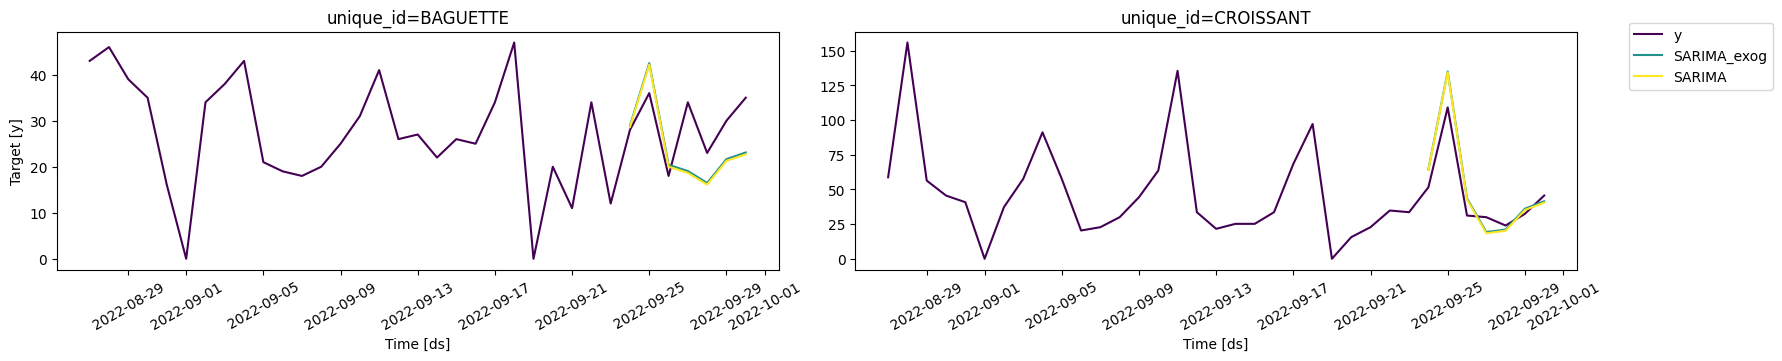

In [44]:
plot_series(
    df=train,
    forecasts_df=test_df,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=28,
    models=["SARIMA_exog", "SARIMA"],
    palette="viridis"
)

In [45]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models=models, freq="D")
cv_exog_df = sf.cross_validation(
    h=horizon, # 7 days
    df=small_df,
    n_windows=8,
    step_size=7,
    refit=True
)

cv_exog_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683


In [46]:
cv_exog_eval = evaluate(
    cv_exog_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_exog_eval = cv_exog_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_exog_eval

,metric,SARIMA_exog
0,mae,19.211687


## Creating features from timestamps

In [47]:
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

features = [
    partial(fourier, season_length=7, k=2),
    partial(time_features, features=["day", "week", "month"])
]

small_exog_df, futr_exog_df = pipeline(
    df=small_df,
    features=features,
    freq="D",
    h=horizon
)

In [48]:
small_exog_df.head()

,unique_id,ds,y,unit_price,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
84,BAGUETTE,2021-01-02,41.4,0.9,0.781832,0.974928,0.623490,-0.222521,2,53,1
85,BAGUETTE,2021-01-03,31.5,0.9,0.974928,-0.433884,-0.222521,-0.900969,3,53,1
86,BAGUETTE,2021-01-04,27.0,0.9,0.433884,-0.781831,-0.900969,0.623490,4,1,1
87,BAGUETTE,2021-01-05,26.1,0.9,-0.433884,0.781832,-0.900969,0.623490,5,1,1
88,BAGUETTE,2021-01-06,0.0,0.9,-0.974928,0.433884,-0.222521,-0.900969,6,1,1


In [49]:
futr_exog_df

,unique_id,ds,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
0,BAGUETTE,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
1,BAGUETTE,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
2,BAGUETTE,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10
3,BAGUETTE,2022-10-04,-0.433861,0.781800,-0.900980,0.623529,4,40,10
4,BAGUETTE,2022-10-05,-0.974933,0.433846,-0.222500,-0.900987,5,40,10
5,BAGUETTE,2022-10-06,-0.781828,-0.974931,0.623495,-0.222509,6,40,10
6,BAGUETTE,2022-10-07,-0.000009,-0.000017,1.000000,1.000000,7,40,10
7,CROISSANT,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
8,CROISSANT,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
9,CROISSANT,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10


In [50]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_time_exog")
]

sf = StatsForecast(models=models, freq="D")
cv_time_exog_df = sf.cross_validation(
    h=horizon, # 7 days
    df=small_exog_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_time_exog_eval = cv_time_exog_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_time_exog_eval

,metric,SARIMA_time_exog
0,mae,19.721581


## Prediction Intervals

In [51]:
unique_ids = ["BAGUETTE", "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]
test = small_df.groupby("unique_id").tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [52]:
train.head()

,unique_id,ds,y,unit_price
0,BAGUETTE,2021-01-02,41.4,0.9
1,BAGUETTE,2021-01-03,31.5,0.9
2,BAGUETTE,2021-01-04,27.0,0.9
3,BAGUETTE,2021-01-05,26.1,0.9
4,BAGUETTE,2021-01-06,0.0,0.9


In [53]:
models = [
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)
prob_preds = sf.predict(h=horizon, X_df=test.drop(["y"], axis=1), level=[80])

In [54]:
test_df = test.merge(prob_preds, on=["unique_id", "ds"], how="left")

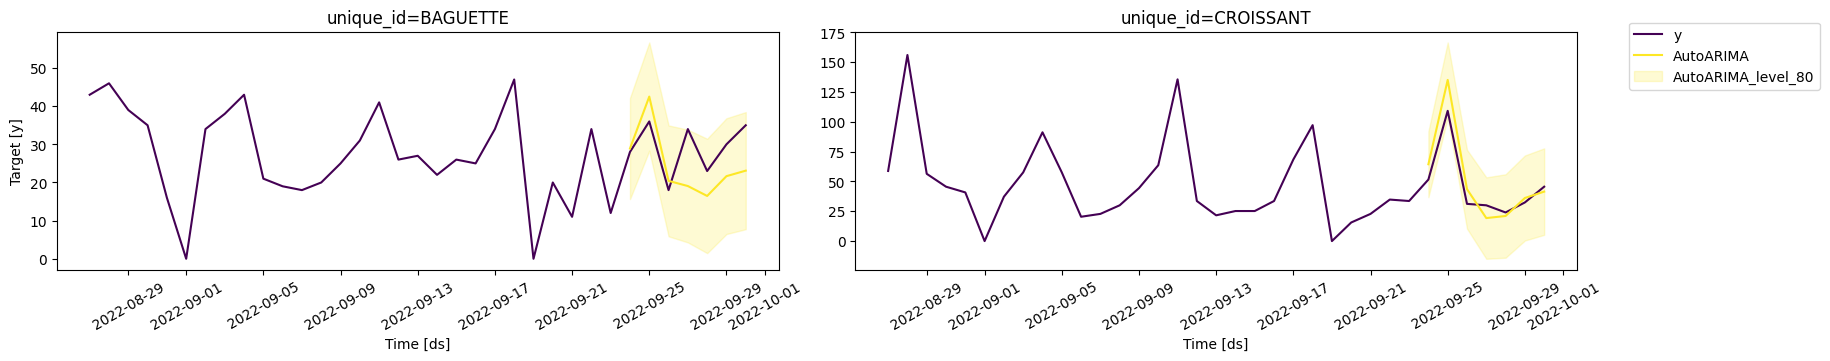

In [55]:
plot_series(
    df=train,
    forecasts_df=test_df,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=28,
    models=["AutoARIMA"],
    level=[80],
    palette="viridis"
)

In [56]:
models = [
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
cv_prob_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=7,
    refit=True,
    level=[80],
)

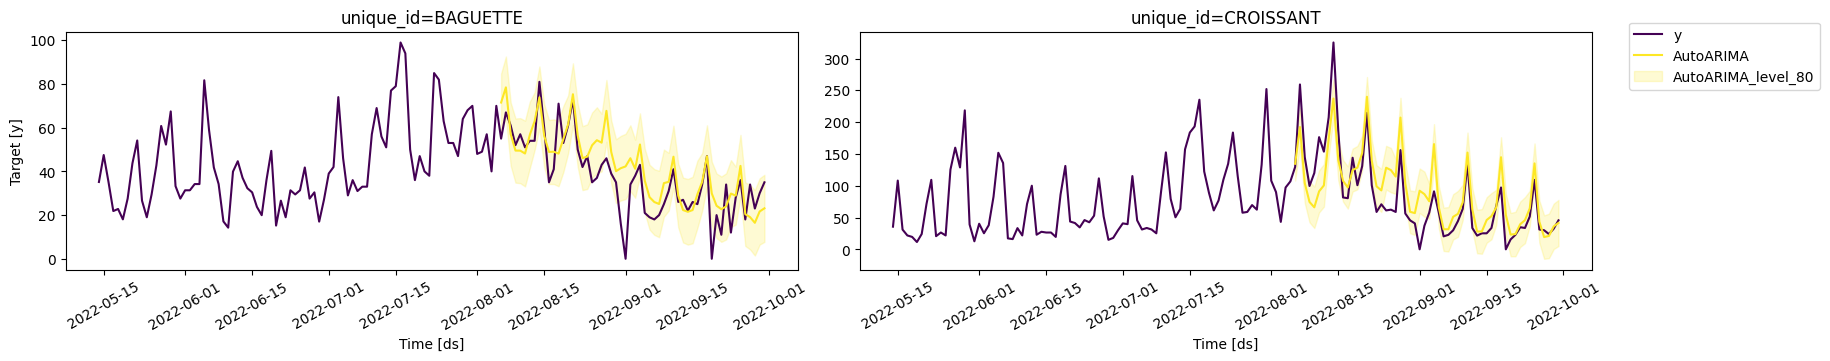

In [57]:
plot_series(
    df=small_df,
    forecasts_df=cv_prob_df.drop(["y", "cutoff"], axis=1),
    ids=["BAGUETTE", "CROISSANT"],
    models=["AutoARIMA"],
    max_insample_length=140,
    level=[80],
    palette="viridis"
)

## Evaluation Metrics

- Depending on the type of forecasts, different evaluation metrics must be used

Point Forecasts
- MAE, MSE, RMSE, sMAPE (symmetric mean absolute ), MASE (Mean Absolute Scaled Error)

Probabilistic Forecasts
- CRPS

For point focus we can use mean aboluste eror, mean squared error, root mean squared error

### MEAN ABOLUTE ERROR (MAE)
- Mean absolute rror, robust to outliers, you equally care about all error size, same units as data

### SYMMETRIC MEAN ABSOLUTE PERCENTAGE ERROR (sMAPE)
- Percentage, equally sensitive to over and under forecasting , avoid if data is close to zero

### MEAN ABSOLUTE SCALED ERROR (MASE)
- Scaled MAE by the MAE of the in-sampe naive forecasts. Good if many series have different scales
- Your metric is already scaled

- insample naive forecast.

### CONTINUOUS RANKED PROBABILITY SCORE (CRPS)
- Generalizaion of the MAE for probabilistic forecasts
- Compares a ground trugh against a cumulative distribution function
- You care about the whole distribution


Asses how well the predicted distribution aligns

- Spread of your distribution,

- Evaluate your distribution

- Evaluation metrics ....

In [58]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog"),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
final_cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=7,
    refit=True,
    level=[80],
)

In [59]:
final_cv_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog,SARIMA_exog-lo-80,SARIMA_exog-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528,58.279213,84.743843,68.0,50.158042,85.841958
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054,64.354114,92.561995,70.0,52.158042,87.841958
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745,42.622201,71.503290,48.0,30.158042,65.841958
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901,34.847356,64.204446,49.0,31.158042,66.841958
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683,34.606853,64.364512,57.0,39.158042,74.841958


In [60]:
temp_test = small_df.groupby("unique_id").tail(7*8)
temp_train = small_df.drop(temp_test.index).reset_index(drop=True)

In [61]:
models = ["SARIMA_exog", "SeasonalNaive"]
metrics = [
    mae,
    mse,
    rmse,
    mape,
    smape,
    partial(mase, seasonality=7),
    scaled_crps
]

final_eval = evaluate(
    final_cv_df.drop(["ds", "cutoff"], axis=1),
    metrics=metrics,
    models=models,
    train_df=temp_train,
    level=[80]
)
final_eval = final_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
final_eval

,metric,SARIMA_exog,SeasonalNaive
0,mae,19.211687,21.117857
1,mape,0.328615,0.376819
2,mase,1.181499,1.328592
3,mse,792.788111,970.417143
4,rmse,24.979598,27.875413
5,scaled_crps,0.153636,0.166451
6,smape,0.168241,0.211317


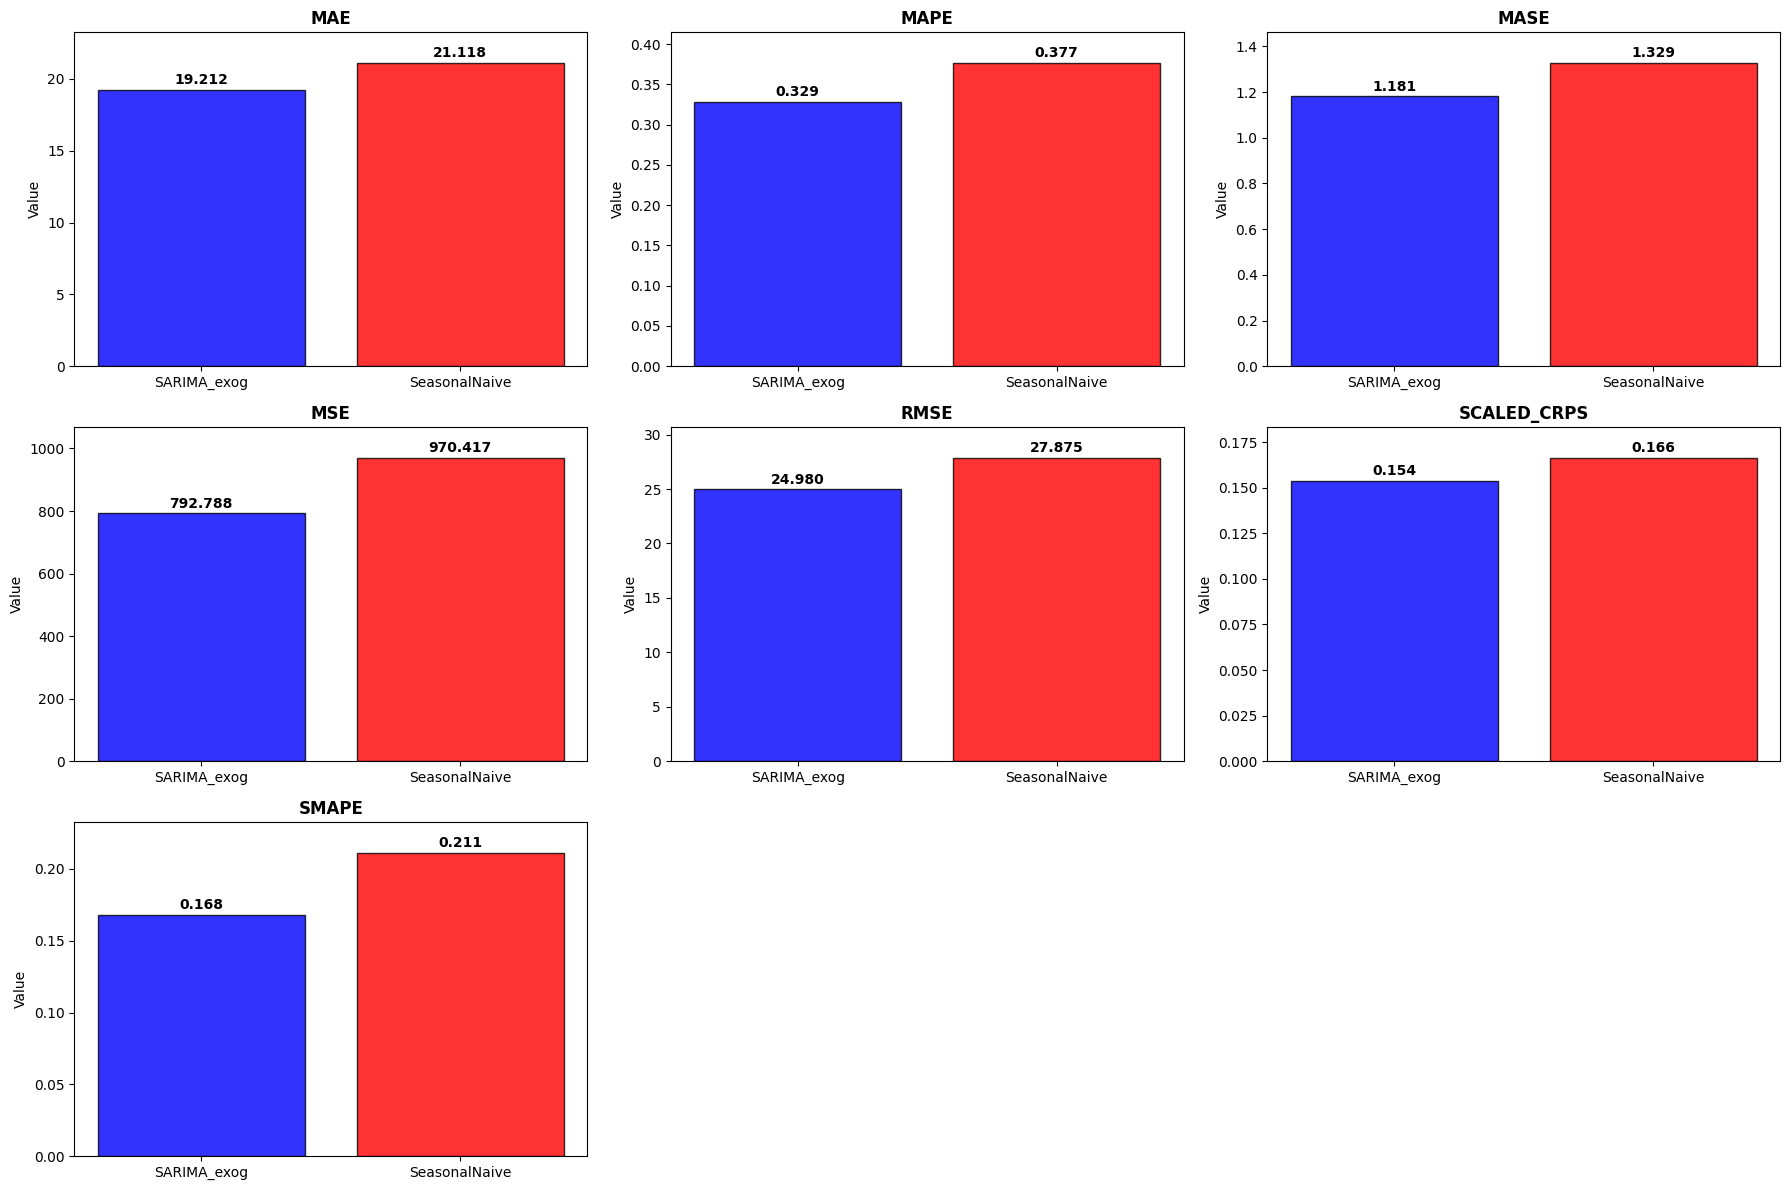

In [62]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

axes_flat = axes.flatten()

models = ['SARIMA_exog', 'SeasonalNaive']
x_pos = [0, 1]
colors = ['blue', 'red']

for i, row in final_eval.iterrows():
    ax = axes_flat[i]

    model_values = [row['SARIMA_exog'], row['SeasonalNaive']]

    bars = ax.bar(x_pos, model_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)

    for j, (bar, value) in enumerate(zip(bars, model_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax.set_title(row['metric'].upper(), fontweight='bold', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models, ha='center')
    ax.set_ylabel('Value')
    max_value = max(model_values)
    ax.set_ylim(0, max_value * 1.1)

fig.delaxes(axes_flat[7])

axes_flat[8].set_visible(False)

plt.tight_layout()
plt.show()